<center><h1>Trabalho Alcoolismo - Curva ROC</h1></center>

##  Busca em um dos parâmetros, treinamento do modelo com o conjunto completo dos dados e salvamento o modelo:

In [1]:
# Leitura da base de dados
import pandas as pd
df = pd.read_csv('alcoolismo_infantil.csv') 

# Separação em variável preditiva e variável resposta
X = df[['goout','absences']] 
y = df['target']

# Separação em treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X,y,test_size=0.3,random_state=42) 

# Busca nos parametros para encontrar o melhor modelo
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
max_depths = [2,3,4,5,6,7,8,9,10] 
f1s = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth,random_state=123)
    dt.fit(X_treino,y_treino)
    y_pred = dt.predict(X_teste)
    f1 = f1_score(y_teste, y_pred)
    
    f1s.append( f1 )
    print( '{max_depth} - {f1:5.4f}'.format(max_depth=max_depth, f1=f1s[-1]) )

# Qual parametros é o melhor?
import numpy as np
best = max_depths[ np.argmax(f1s) ]

# Ajuste do melhor modelo com a base completa
dt.fit(X, y)

# Salvar o melhor modelo em um arquivo
import joblib
joblib.dump(dt, 'modelo_dt.joblib')

2 - 0.4118
3 - 0.4737
4 - 0.4375
5 - 0.4242
6 - 0.4571
7 - 0.4571
8 - 0.4571
9 - 0.4118
10 - 0.4571


['modelo_dt.joblib']

In [2]:
print('O melhor max_depth foi {best}'.format(best=best))
dt = DecisionTreeClassifier(max_depth=best,random_state=42)
dt.fit(X_treino, y_treino)

from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_teste, dt.predict(X_teste))
recall = recall_score(y_teste, dt.predict(X_teste))
print('Precision: {p}'.format(p=precision))
print('Recall: {p}'.format(p=recall))

O melhor max_depth foi 3
Precision: 0.6
Recall: 0.391304347826087


In [3]:
y_teste.mean()

0.19327731092436976

In [4]:
dt.predict(X_teste).mean()

0.12605042016806722

Procuro detectar estudantes com um problema de alcolismo para encaminhá-los para uma psicóloga qualificada.

Em CONJUNTO TESTE, com dados que o modelo nunca viu antes durante o treinamento:
 - <b>Precision</b>: De todos que o modelo solicitou que encaminhasse para a psicóloga, 60% realmente tinham um problema. Isso quer dizer que <u>estamos desperdiçando nosso recurso (tempo da psicóloga) 40% das vezes</u>. Além disso, caso enviasse alunos aleatoriamente para a psicóloga, como há 20% dos estudantes com problemas, desperdissaria 80% das vezes.
 - <b>Recall</b>: De todos os alunos alcolistas, detectei 40% deles. Lembrando que o modelo solicitou que eu encaminhasse somente 12.6% dos alunos para a psicóloga (linha `dt.predict(X_teste).mean()`: Qual a fração de preditos como alcolista em relação a base toda). Ou seja: Apesar de eu enviar pouca gente, tive uma taxa de acertos relativamente boa.

In [5]:
dt.predict(X_teste)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1])

In [6]:
dt.predict(X_teste).sum(),len(X_teste)

(15, 119)

Aqui conseguimos observar números absolutos: de 119 alunos no conjunto teste, 15 foram encaminhados para a psicóloga.

O que da mais de <b>10% da escola!</b>

Supondo que a psicóloga possui agenda para mais alunos que isso, que ela quer que enviemos mais gente, uma vez que ela sabe que não capturamos todos. Mas queremos mandar somente aqueles que temos um pouco mais de certeza da situação. Como posso fazer isso?

Agora vou procurar fazer um ordenamento.

Para isso, vamos relembrar como a árvore de decisão funciona. Vamos VISUALIZAR as regras geradas pela árvore:

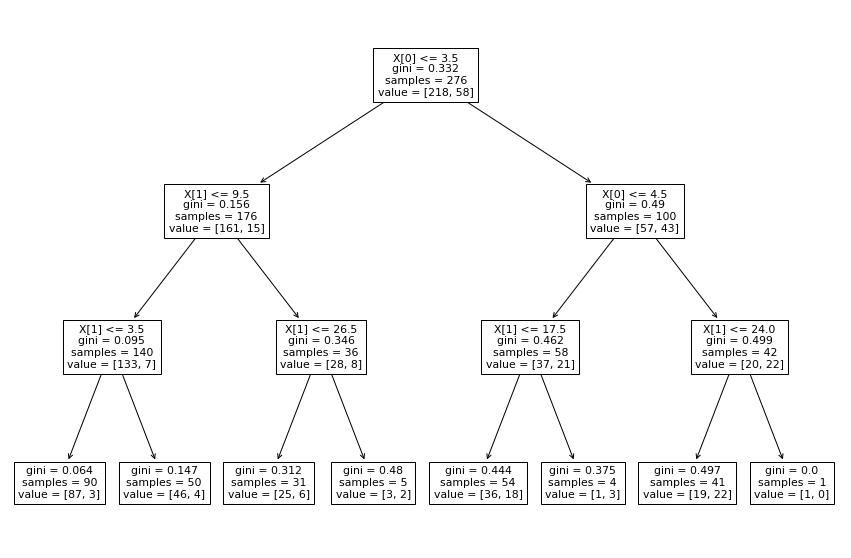

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
#Acabei tendo que ajustar o tamanho com figsize
plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)
plot_tree(dt,ax=ax);

Vale a pena observar pra folha mais da esquerda. Passando pelas regras, a árvore mandou 90 alunos pra lá, sendo que apenas 3 eram alcolistas. <b>96% deles não tinham nenhum problema</b>. Se formos ordenar, qual o **score de alcolismo** que poderíamos dar para esses alunos:<b> 3/90!</b>
É considerado quase como uma "probabilidade de encontrar um aluno alcolista nessa folha". Por razões técnicas não podemos falar que é uma probabilidade mesmo, mas ordena. Quanto maior esse número, maior a chance de ser alcolista.

In [8]:
3/90

0.03333333333333333

E na próxima folha:

In [9]:
4/50

0.08

Mas por que não é considerado probabilidade?
Basicamente porque isso se trata de um problema de amostragem, tínhamos uma base pequena, e, em particular, somente 1 aluno com a sequência de características que foram filtradas por essa regra. O <u>estimador dessa probabilidade</u> não é bom, ele se distancia muito da *probabilidade real*.

<hr/>

Para 'pegar' esses **scores** usaremos a função `predict_proba` ao invés de usarmos a `predict`:

In [10]:
dt.predict_proba(X_teste)

array([[0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.92      , 0.08      ],
       [0.66666667, 0.33333333],
       [0.66666667, 0.33333333],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.80645161, 0.19354839],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.92      , 0.08      ],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.66666667, 0.33333333],
       [0.66666667, 0.33333333],
       [0.66666667, 0.33333333],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.66666667, 0.33333333],
       [0.66666667, 0.33333333],
       [0.46341463, 0.53658537],
       [0.96666667, 0.03333333],
       [0.66666667, 0.33333333],
       [0.96666667, 0.03333333],
       [0.80645161, 0.19354839],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.92      , 0.08      ],
       [0.

 - Cada linha é o score de um aluno.
 - A primeira coluna (coluna 0) é o score de NÃO ser alcolista (target=0)
 - A segunda coluna (coluna 1) é o score de SER acolista (target=1)

     **As duas colunas sempre somam 1**

Como a base é muito *desbalanceada*, existe o efeito que ter muito mais score de alcolismo baixos que altos, simplesmente porque como tem mais alunos não alcolistas, é mais provável deles cairem em qualquer uma das folhas

<hr />

In [11]:
preds1 = dt.predict_proba(X_teste)[:,1] > 0.50
preds2 = dt.predict(X_teste)

preds1 == preds2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

# Escolhendo o limiar:

Primeiro, vou dar uma olhada na *distribuição* desses scores com um gráfico de barras, o:
- O *eixo-x* são intervalos de score;
- O *eixo-y* é a contagem de quantas pessoas cairam naquele intervalo de score;

 - Em azul, o histograma somente para os alunos a classe 0, não alcolistas
 - Em vermelho, o histograma somente para os alunos a classe 1, alcolistas

(array([40., 22.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0., 18.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.]),
 array([0.03333333, 0.05722222, 0.08111111, 0.105     , 0.12888889,
        0.15277778, 0.17666667, 0.20055556, 0.22444444, 0.24833333,
        0.27222222, 0.29611111, 0.32      , 0.34388889, 0.36777778,
        0.39166667, 0.41555556, 0.43944444, 0.46333333, 0.48722222,
        0.51111111, 0.535     , 0.55888889, 0.58277778, 0.60666667,
        0.63055556, 0.65444444, 0.67833333, 0.70222222, 0.72611111,
        0.75      ]),
 <BarContainer object of 30 artists>)

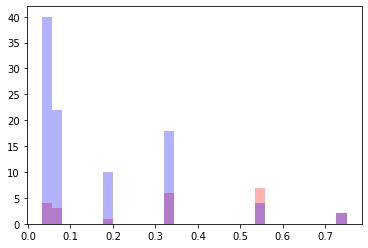

In [12]:
alcolistas  = y_teste==1
nalcolistas = y_teste==0

pred = dt.predict_proba(X_teste)[:,1]

plt.hist(pred[ alcolistas],bins=30,color='r',alpha=.3)
plt.hist(pred[nalcolistas],bins=30,color='b',alpha=.3)

As barras vermelhas são todas muito pequenas. **Isso é efeito do desbalanceamento da base**. 
Pra ter uma comparação justa, vamos usar o parâmetro `density=True`, isso faz com que os 2 histogramas possuam *a mesma área*. 

Com isso a altura da barra vermelha agora é *proporcional a probabilidade de encontrar um alcolista quando olhamos praquele intervalo de score*. E similarmente para as barras azuis.

Agora os 2 tem um eixo-y comparável: Uma **estimativa** diretamente proporcional à probabilidade

(array([17.44186047,  9.59302326,  0.        ,  0.        ,  0.        ,
         0.        ,  4.36046512,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  7.84883721,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.74418605,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.87209302]),
 array([0.03333333, 0.05722222, 0.08111111, 0.105     , 0.12888889,
        0.15277778, 0.17666667, 0.20055556, 0.22444444, 0.24833333,
        0.27222222, 0.29611111, 0.32      , 0.34388889, 0.36777778,
        0.39166667, 0.41555556, 0.43944444, 0.46333333, 0.48722222,
        0.51111111, 0.535     , 0.55888889, 0.58277778, 0.60666667,
        0.63055556, 0.65444444, 0.67833333, 0.70222222, 0.72611111,
        0.75      ]),
 <BarContainer object of 30 artists>)

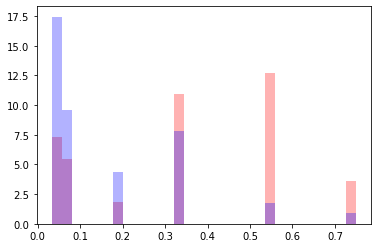

In [13]:
alcolistas  = y_teste==1
nalcolistas = y_teste==0

pred = dt.predict_proba(X_teste)[:,1]

plt.hist(pred[ alcolistas],bins=30,color='r',alpha=.3,density=True)
plt.hist(pred[nalcolistas],bins=30,color='b',alpha=.3,density=True)

Agora sim: Comparando as barras, vemos que se escolhermos um limiar acima de 0.30, vamos mandar mais gente pra psicóloga, como ela pediu, e ainda vamos estar mandando, proporcionalmente, mais alcolistas que não alcolistas, pois a barra vermelha é maior que a azul.

Nessa faixa de score temos PROPORCIONALMENTE mais alcolistas que a média da base, situação que enviaríamos alunos aleatoriamente.

### Mas vamos olhar agora para o conceito de CURVA ROC para ajudar a olhar pra esses scores. 

Pra isso, vamos definir 2 indicadores:

## True positive rate (TPR)
Recall = de todos alcolistas, quanto meu modelo acerta?
Quanto mais pra esquerda no histograma, maior

## False positive rate (FPR)
De todos não alcolistas, quantos eu errei e disse que eram?
Quando mais pra esquerda no histograma, maior

<hr/>

Procuro **maximizar** a TPR ao mesmo tempo que **minimizamos** a FPR.


**True Positive Rate em limiar 0.7:**

In [14]:
(pred[alcolistas]>0.7).sum()/len(alcolistas)

0.01680672268907563

**True Negative Rate em limiar 0.7:**

In [15]:
(pred[nalcolistas]>0.7).sum()/len(nalcolistas)

0.01680672268907563

**True Positive Rate em limiar 0.5:**

In [16]:
(pred[alcolistas]>0.5).sum()/len(alcolistas)

0.07563025210084033

**True Negative Rate em limiar 0.5:**

In [17]:
(pred[nalcolistas]>0.5).sum()/len(nalcolistas)

0.05042016806722689

**True Positive Rate em limiar 0.3:**

In [18]:
(pred[alcolistas]>0.5).sum()/len(alcolistas)

0.07563025210084033

**True Negative Rate em limiar 0.3:**

In [19]:
(pred[nalcolistas]>0.5).sum()/len(nalcolistas)

0.05042016806722689

<hr/>

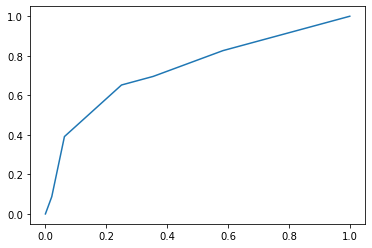

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, ths = roc_curve(y_teste, dt.predict_proba(X_teste)[:,1])

plt.plot(fpr,tpr)

### Fazendo uma plotagem mais detalhada:

Text(0, 0.5, 'True positive rate')

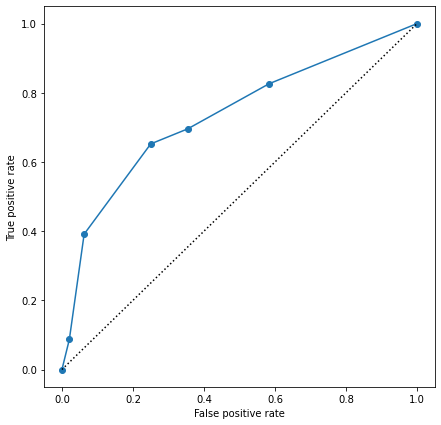

In [21]:
plt.figure(figsize=(7,7))
plt.plot(fpr,tpr,marker='o')
plt.plot([0,1],[0,1],linestyle=':',color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

Quanto mais **vertical** a linha que liga 2 pontos melhor: pago um pequeno preço mandando alguns não alcolistas pra psicóloga, e em contrapartida mando MUITOS que realmente precisam.

Mas quando mais **horizontal** pior. Mando muita gente que não precisava pra acertar poucos alcolistas a mais.

Logo,

**Para aumentar TPR eu pago um preço em aumentar a FPR**

**Em qual curva eu pago o menor preço?**

# Como fica para os outros modelos?

Text(0, 0.5, 'True positive rate')

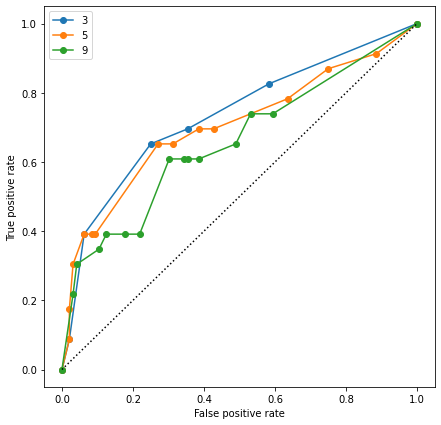

In [22]:
max_depths = [3,5,9]
plt.figure(figsize=(7,7))
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_treino, y_treino)
    fpr,tpr,ths = roc_curve(y_teste, dt.predict_proba(X_teste)[:,1])
    plt.plot(fpr,tpr,marker='o',label=max_depth)
plt.plot([0,1],[0,1],linestyle=':',color='k')
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

Isso CONFIRMOU o que se observou com o F1 de limiar 0.50. O modelo com profundidade 3 é o melhor pra praticamente todos os limiares!

A prática correta é olhar para a **ÁREA SOB A CURVA ROC**, ou **AUC**. Isso vai nos dizer se o modelo é bom em média para TODOS os limiares possíveis! Ou se há *algum limiar que a classificação é melhor*.

# Refazendo o código
Mas agora com auc

Vamos usar a `roc_auc_score`

In [23]:
# Leitura da base de dados
import pandas as pd
df = pd.read_csv('alcoolismo_infantil.csv') 

# Separação em variável preditiva e variável resposta
X = df[['goout','absences']] 
y = df['target']

# Separação em treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X,y,test_size=0.3,random_state=42) 

# Busca nos parametros para encontrar o melhor modelo
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
max_depths = [2,3,4,5,6,7,8,9,10] 
aucs = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth,random_state=123)
    dt.fit(X_treino,y_treino)
    y_pred = dt.predict(X_teste)
    auc = roc_auc_score(y_teste, y_pred)
    
    aucs.append( auc )
    print( '{max_depth} - {auc:5.4f}'.format(max_depth=max_depth, auc=aucs[-1]) )

# Qual parametros é o melhor?
import numpy as np
best = max_depths[ np.argmax(aucs) ]

# Ajuste do melhor modelo com a base completa
dt.fit(X, y)

# Salvar o melhor modelo em um arquivo
import joblib
joblib.dump(dt, 'modelo_dt.joblib')

2 - 0.6313
3 - 0.6644
4 - 0.6418
5 - 0.6365
6 - 0.6531
7 - 0.6531
8 - 0.6531
9 - 0.6313
10 - 0.6531


['modelo_dt.joblib']

In [24]:
best

3

Mas e agora??? Como eu escolho O MELHOR LIMIAR, caso isso seja necessário?

Agora podemos voltar para nossa precision recall!! Vamos olhar para como essas métricas se comportam ao longos dos limiares (usando função pronta, claro!)

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

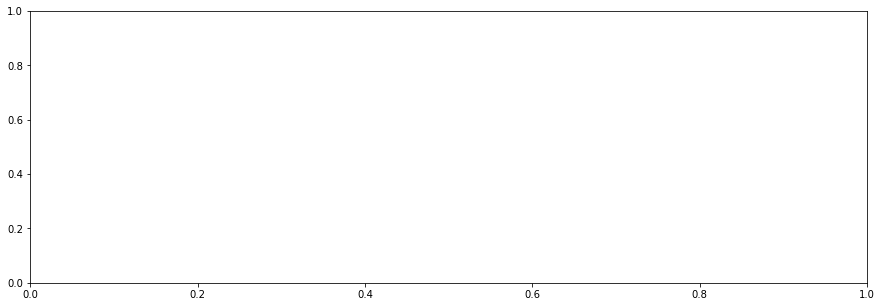

In [25]:
from sklearn.metrics import precision_recall_curve
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

dt = DecisionTreeClassifier(max_depth=best)
dt.fit(X_treino, y_treino)
prec, rec, ths = precision_recall_curve(y_teste,dt.predict_proba(X_teste)[:,1])

f1 = 2/((1/prec)+(1/rec))

plt.figure(figsize=(15,5))
plt.plot(ths,f1)

Vale a pena ressaltar a razão de ter dado erro nesse código.

Essa função varia o limiar calculando o precision e o recall.

Mas para cada valor de precision e recall, ele volta o limiar logo antes e logo depois. Isso faz com que tenhamos um limiar a mais que o necessário.

Pra minha finalidade, vou só "jogar fora" o último ponto (sintaxe: `vetor[:-1]`: Pegue todos exceto o último)

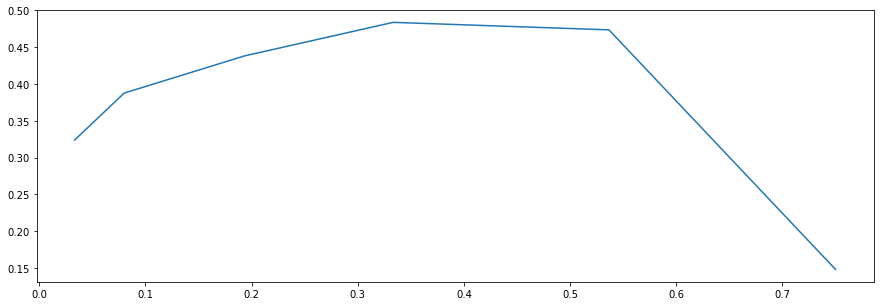

In [26]:
from sklearn.metrics import precision_recall_curve
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

dt = DecisionTreeClassifier(max_depth=best)
dt.fit(X_treino, y_treino)
prec, rec, ths = precision_recall_curve(y_teste,dt.predict_proba(X_teste)[:,1])

f1 = 2/((1/prec)+(1/rec))

plt.figure(figsize=(15,5))
plt.plot(ths,f1[:-1])

(array([17.44186047,  9.59302326,  0.        ,  0.        ,  0.        ,
         0.        ,  4.36046512,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  7.84883721,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.74418605,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.87209302]),
 array([0.03333333, 0.05722222, 0.08111111, 0.105     , 0.12888889,
        0.15277778, 0.17666667, 0.20055556, 0.22444444, 0.24833333,
        0.27222222, 0.29611111, 0.32      , 0.34388889, 0.36777778,
        0.39166667, 0.41555556, 0.43944444, 0.46333333, 0.48722222,
        0.51111111, 0.535     , 0.55888889, 0.58277778, 0.60666667,
        0.63055556, 0.65444444, 0.67833333, 0.70222222, 0.72611111,
        0.75      ]),
 <BarContainer object of 30 artists>)

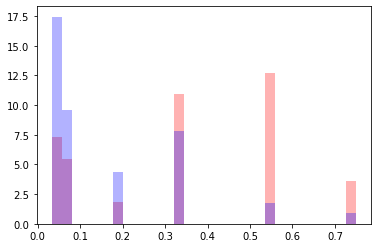

In [27]:
alcolistas  = y_teste==1
nalcolistas = y_teste==0

pred = dt.predict_proba(X_teste)[:,1]

plt.hist(pred[ alcolistas],bins=30,color='r',alpha=.3,density=True)
plt.hist(pred[nalcolistas],bins=30,color='b',alpha=.3,density=True)